In [1]:
import os
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim 
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from datetime import datetime
import torchvision.models as models


In [2]:
# 画像のサイズ
IMG_SIZE = 260

# データのディレクトリのパス
FLOWER_DIR = '../input/flowers'

batch_size = 32

model_name = "EfficientNetb2"

In [3]:
# GPUが利用可能かどうかを確認し、利用可能ならGPUを使用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


# データセットの作成

In [4]:
transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # 画像サイズをリサイズ,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットを作成
dataset = datasets.ImageFolder(FLOWER_DIR, transform=transforms)


In [5]:
# 学習データに使用する割合
n_train_ratio = 0.8

# 割合から個数を出す
n_train = int(len(dataset) * n_train_ratio)
n_val   = int(len(dataset) - n_train)


In [6]:
# 学習データと検証データに分割
train, val = random_split(dataset, [n_train, n_val])


In [7]:
# Data Loader
train_loader = DataLoader(train, batch_size, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val, batch_size, num_workers=2)


In [8]:

class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNet, self).__init__()
        self.efficientnet = models.efficientnet_b2(weights="IMAGENET1K_V1") 
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier[1] = nn.Linear(in_features, num_classes)  # 新しい最終層を追加

    def forward(self, x):
        return self.efficientnet(x)


In [9]:
# 2. モデルの構築
model = CustomEfficientNet(num_classes=5).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /home/taisei/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 56.5MB/s]


In [10]:
# 3. 訓練と検証
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)



In [11]:
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train()
        train_loss, train_correct = 0, 0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Training...'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        # 検証フェーズ
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Validation...'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        # 損失と精度の計算
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_correct / len(train_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [12]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.24it/s]


Epoch 1/50, Train Loss: 0.4817326761016222, Val Loss: 0.30957523319456315, Train Acc: 0.8328989284679988, Val Acc: 0.9039351851851852


Epoch 2/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.11it/s]


Epoch 2/50, Train Loss: 0.2401500421567498, Val Loss: 0.24985579815175799, Train Acc: 0.91167101071532, Val Acc: 0.9259259259259259


Epoch 3/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.05it/s]


Epoch 3/50, Train Loss: 0.19693689373817957, Val Loss: 0.235780730843544, Train Acc: 0.9270199826238054, Val Acc: 0.9201388888888888


Epoch 4/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.07it/s]


Epoch 4/50, Train Loss: 0.18031987711508699, Val Loss: 0.25070738906247747, Train Acc: 0.9377353026353895, Val Acc: 0.9166666666666666


Epoch 5/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.13it/s]


Epoch 5/50, Train Loss: 0.14489503969029288, Val Loss: 0.27541024503470574, Train Acc: 0.9432377642629598, Val Acc: 0.9305555555555556


Epoch 6/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.16it/s]


Epoch 6/50, Train Loss: 0.1255998067823282, Val Loss: 0.23427360435878788, Train Acc: 0.9493194323776426, Val Acc: 0.9212962962962963


Epoch 7/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.15it/s]


Epoch 7/50, Train Loss: 0.09231912938738678, Val Loss: 0.4129894720045505, Train Acc: 0.9603243556327831, Val Acc: 0.9120370370370371


Epoch 8/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.16it/s]


Epoch 8/50, Train Loss: 0.1146073619112651, Val Loss: 0.24239198284016716, Train Acc: 0.9562699102229945, Val Acc: 0.9340277777777778


Epoch 9/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.17it/s]


Epoch 9/50, Train Loss: 0.0688612965940907, Val Loss: 0.33226664764461694, Train Acc: 0.9678540399652477, Val Acc: 0.9340277777777778


Epoch 10/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.17it/s]


Epoch 10/50, Train Loss: 0.08819870185977388, Val Loss: 0.3101640754137878, Train Acc: 0.9669852302345786, Val Acc: 0.9305555555555556


Epoch 11/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.12it/s]


Epoch 11/50, Train Loss: 0.08711358152817343, Val Loss: 0.2737087763983894, Train Acc: 0.9617723718505647, Val Acc: 0.9351851851851852


Epoch 12/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.07it/s]


Epoch 12/50, Train Loss: 0.06567212338037093, Val Loss: 0.31325706494627176, Train Acc: 0.9721980886185926, Val Acc: 0.9178240740740741


Epoch 13/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.24it/s]


Epoch 13/50, Train Loss: 0.08000231969875292, Val Loss: 0.22420872175307185, Train Acc: 0.9643788010425717, Val Acc: 0.9363425925925926


Epoch 14/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.15it/s]


Epoch 14/50, Train Loss: 0.07481570762721386, Val Loss: 0.2818577913739891, Train Acc: 0.9675644367216912, Val Acc: 0.9282407407407407


Epoch 15/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.12it/s]


Epoch 15/50, Train Loss: 0.09058683402792803, Val Loss: 0.31303964948488605, Train Acc: 0.9675644367216912, Val Acc: 0.9259259259259259


Epoch 16/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.01it/s]


Epoch 16/50, Train Loss: 0.06363405335191899, Val Loss: 0.2330949782497353, Train Acc: 0.9710396756443672, Val Acc: 0.9398148148148148


Epoch 17/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.11it/s]


Epoch 17/50, Train Loss: 0.07156775546451664, Val Loss: 0.31372632803740325, Train Acc: 0.9690124529394729, Val Acc: 0.9317129629629629


Epoch 18/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.19it/s]


Epoch 18/50, Train Loss: 0.06295887279219786, Val Loss: 0.2279434679765944, Train Acc: 0.9727772951057052, Val Acc: 0.9270833333333334


Epoch 19/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.08it/s]


Epoch 19/50, Train Loss: 0.045280482038468226, Val Loss: 0.27821333016510363, Train Acc: 0.9750941210541558, Val Acc: 0.9201388888888888


Epoch 20/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.14it/s]


Epoch 20/50, Train Loss: 0.06643080087400381, Val Loss: 0.2461267409035591, Train Acc: 0.9687228496959166, Val Acc: 0.9317129629629629


Epoch 21/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.10it/s]


Epoch 21/50, Train Loss: 0.03412592081923177, Val Loss: 0.2453381637568344, Train Acc: 0.9794381697075007, Val Acc: 0.9409722222222222


Epoch 22/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.17it/s]


Epoch 22/50, Train Loss: 0.03220171332138995, Val Loss: 0.3178891207057017, Train Acc: 0.981465392412395, Val Acc: 0.9305555555555556


Epoch 23/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.20it/s]


Epoch 23/50, Train Loss: 0.06702687248487513, Val Loss: 0.4972588430952143, Train Acc: 0.9736461048363741, Val Acc: 0.9004629629629629


Epoch 24/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.02it/s]


Epoch 24/50, Train Loss: 0.06750865497356542, Val Loss: 0.3620640669983846, Train Acc: 0.9695916594265855, Val Acc: 0.9201388888888888


Epoch 25/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.06it/s]


Epoch 25/50, Train Loss: 0.058721730451830705, Val Loss: 0.26143807971298144, Train Acc: 0.9733565015928178, Val Acc: 0.9282407407407407


Epoch 26/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.09it/s]


Epoch 26/50, Train Loss: 0.035165925436788106, Val Loss: 0.324452663478614, Train Acc: 0.9800173761946134, Val Acc: 0.9293981481481481


Epoch 27/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.11it/s]


Epoch 27/50, Train Loss: 0.06275704814497574, Val Loss: 0.3763977316794572, Train Acc: 0.9724876918621489, Val Acc: 0.9131944444444444


Epoch 28/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.33it/s]


Epoch 28/50, Train Loss: 0.0559375672492364, Val Loss: 0.22115897762382197, Train Acc: 0.9748045178105995, Val Acc: 0.9502314814814815


Epoch 29/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.49it/s]


Epoch 29/50, Train Loss: 0.03094690971546502, Val Loss: 0.2839340155047399, Train Acc: 0.9788589632203881, Val Acc: 0.9247685185185185


Epoch 30/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.65it/s]


Epoch 30/50, Train Loss: 0.04782225511517706, Val Loss: 0.28895225032681116, Train Acc: 0.9779901534897191, Val Acc: 0.9224537037037037


Epoch 31/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.52it/s]


Epoch 31/50, Train Loss: 0.04826115313960918, Val Loss: 0.3506050191267773, Train Acc: 0.9739357080799305, Val Acc: 0.9201388888888888


Epoch 32/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.64it/s]


Epoch 32/50, Train Loss: 0.07407027074336031, Val Loss: 0.31049813947605864, Train Acc: 0.9695916594265855, Val Acc: 0.9363425925925926


Epoch 33/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.51it/s]


Epoch 33/50, Train Loss: 0.04040055915973885, Val Loss: 0.46026433542094847, Train Acc: 0.9774109470026064, Val Acc: 0.9282407407407407


Epoch 34/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.41it/s]


Epoch 34/50, Train Loss: 0.05637244713355604, Val Loss: 0.42073983174783214, Train Acc: 0.9739357080799305, Val Acc: 0.8981481481481481


Epoch 35/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.53it/s]


Epoch 35/50, Train Loss: 0.06741874063252602, Val Loss: 0.278594582307118, Train Acc: 0.9661164205039097, Val Acc: 0.9328703703703703


Epoch 36/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.56it/s]


Epoch 36/50, Train Loss: 0.04622136258137212, Val Loss: 0.24493871879315487, Train Acc: 0.9791485664639444, Val Acc: 0.9317129629629629


Epoch 37/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.53it/s]


Epoch 37/50, Train Loss: 0.02363427850025027, Val Loss: 0.2642773976377039, Train Acc: 0.9826238053866203, Val Acc: 0.9398148148148148


Epoch 38/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.61it/s]


Epoch 38/50, Train Loss: 0.05236445689980793, Val Loss: 0.3615619070931441, Train Acc: 0.9777005502461628, Val Acc: 0.9120370370370371


Epoch 39/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.70it/s]


Epoch 39/50, Train Loss: 0.04991945778574603, Val Loss: 0.28493672685214766, Train Acc: 0.9753837242977121, Val Acc: 0.9224537037037037


Epoch 40/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.63it/s]


Epoch 40/50, Train Loss: 0.04025308253509036, Val Loss: 0.24244266677716816, Train Acc: 0.9762525340283811, Val Acc: 0.9328703703703703


Epoch 41/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.51it/s]


Epoch 41/50, Train Loss: 0.04593948012861972, Val Loss: 0.2581560658118515, Train Acc: 0.9791485664639444, Val Acc: 0.9328703703703703


Epoch 42/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.57it/s]


Epoch 42/50, Train Loss: 0.03555378838084316, Val Loss: 0.31457894597271524, Train Acc: 0.9788589632203881, Val Acc: 0.9328703703703703


Epoch 43/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.59it/s]


Epoch 43/50, Train Loss: 0.03072706536443199, Val Loss: 0.33212151330102374, Train Acc: 0.9800173761946134, Val Acc: 0.9317129629629629


Epoch 44/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 10.42it/s]


Epoch 44/50, Train Loss: 0.038389616822331565, Val Loss: 0.2693255812412611, Train Acc: 0.9800173761946134, Val Acc: 0.9456018518518519


Epoch 45/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.03it/s]


Epoch 45/50, Train Loss: 0.036197051225027733, Val Loss: 0.268128962368118, Train Acc: 0.9794381697075007, Val Acc: 0.9432870370370371


Epoch 46/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.71it/s]


Epoch 46/50, Train Loss: 0.02836697169190064, Val Loss: 0.2725374279522199, Train Acc: 0.9820445988995077, Val Acc: 0.9444444444444444


Epoch 47/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 12.85it/s]


Epoch 47/50, Train Loss: 0.039530986329218566, Val Loss: 0.2978850550113108, Train Acc: 0.980596582681726, Val Acc: 0.9363425925925926


Epoch 48/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 10.80it/s]


Epoch 48/50, Train Loss: 0.01796165595197491, Val Loss: 0.35585352540430093, Train Acc: 0.9849406313350709, Val Acc: 0.9247685185185185


Epoch 49/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.20it/s]


Epoch 49/50, Train Loss: 0.03744761861447859, Val Loss: 0.4024823142077636, Train Acc: 0.9774109470026064, Val Acc: 0.9212962962962963


Epoch 50/50, Validation...: 100%|██████████| 27/27 [00:02<00:00, 13.14it/s]

Epoch 50/50, Train Loss: 0.03144145332458788, Val Loss: 0.3237771466589981, Train Acc: 0.9808861859252823, Val Acc: 0.9293981481481481


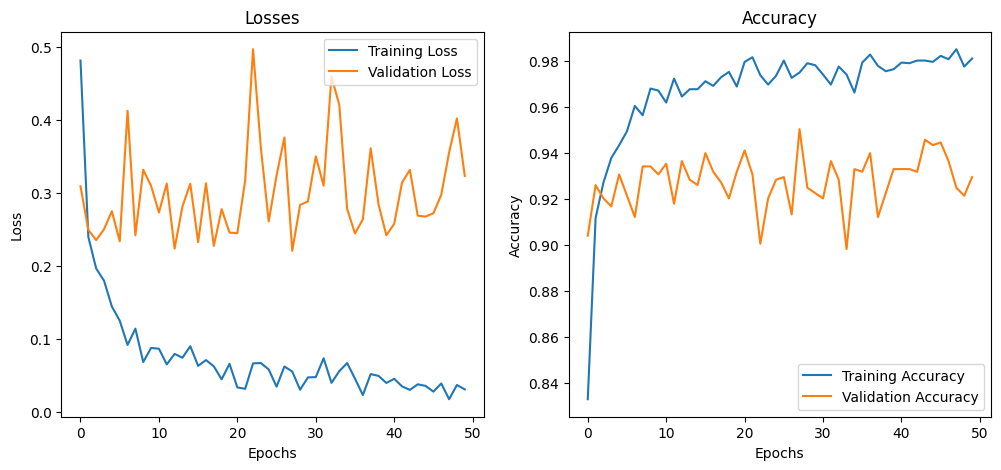

In [13]:
# グラフを保存するディレクトリを作成
output_dir = '../results'
os.makedirs(output_dir, exist_ok=True)

# タイムスタンプを生成
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# LossとAccuracyのデータをCSVファイルに保存
csv_filename = os.path.join(output_dir, f'{model_name}_{timestamp}.csv')
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    
    for epoch in range(len(train_losses)):
        writer.writerow([epoch+1, train_losses[epoch], val_losses[epoch], train_accuracies[epoch], val_accuracies[epoch]])


# Lossのグラフを保存
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracyのグラフを保存
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title(f'Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 画像を保存
plt.savefig(os.path.join(output_dir, f'{model_name}_{timestamp}.png'))

# 画像を表示
plt.show()
